In [1]:
import numpy as np
import cv2 as cv
from src.feature_matching import matching
from src.affine import RANSAC, get_affine

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": ["Arial"],           
    "font.sans-serif": ["DejaVu Sans"], 
    "pgf.texsystem": "pdflatex"
}
sns.set_style(style='white',rc=pgf_with_rc_fonts)

def hide_box(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [3]:
def pinv(A):
    '''
    https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.9-The-Moore-Penrose-Pseudoinverse/
    '''
    U, D, V = np.linalg.svd(A)

    D_plus = np.zeros((A.shape[0], A.shape[1])).T
    
    under_D = 1/D #this is the inverse of D, because D is a diagonal matrix
    
    D_inv = np.zeros((under_D.shape[0],under_D.shape[0]))
    
    row,col = np.diag_indices(D_inv.shape[0])
    
    D_inv[row,col] = under_D
    
    D_plus[:D.shape[0], :D.shape[0]] = D_inv

    A_plus = V.T.dot(D_plus).dot(U.T)
    
    return A_plus

In [4]:
def affine(original, transformed):
    # checking dimensions
    assert (original.shape[1] == 2)
    assert (transformed.shape[1] == 2)
    assert (transformed.shape[0] == original.shape[0])

    # building the X matrix
    matches_count = original.shape[0]
    zeros = np.zeros((matches_count, 3))
    coordinates_with_1 = np.append(original, np.ones((matches_count, 1)), axis=1)
    x_left = np.column_stack((coordinates_with_1, zeros)).reshape(2 * matches_count, 3)
    x_right = np.column_stack((zeros, coordinates_with_1)).reshape(2 * matches_count, 3)
    x = np.column_stack((x_left, x_right)).astype(int)

    # building the Y matrix
    y = transformed.reshape((2 * matches_count, 1))

    return x, pinv(x.T.dot(x)).dot(x.T.dot(y)), y

In [5]:
def comp_points(model):
    a,b,c,d,e,f = model.flatten().tolist()
    def comp_(point):
        x_ = point[0]*a + point[1]*b + c
        y_ = point[0]*d + point[1]*e + f
        
        return x_,y_
    return comp_

def fit(original, transformed):
    return affine(original, transformed)

def comp_error(original, transformed, model):
    transformation = comp_points(model)
    B_fit = np.apply_along_axis( transformation, axis=1, arr=original)
    
    return np.sum((transformed-B_fit)**2,axis=1)

In [6]:
# def RANSAC(original, transformed, n, k, t, d):
#     """
#     Implementation from pseudocode at
#     https://en.wikipedia.org/wiki/Random_sample_consensus
    
#     :param original: array (M x 2) containing the coordinates in the original image - one coordinate [x,y] per row
#     :param transformed: array (M x 2) containing the coordinates in the transformed image - one coordinate [x,y] per row
#     :param n:        the minimum number of data values required to fit the model
#     :param k:        the maximum number of iterations allowed in the algorithm
#     :param t:        a threshold value for determining when a data point fits a model
#     :param d:        the number of close data values required to assert that a model fits well to data
#     :return bestfit: model parameters which best fit the data (or nil if no good model is found)
#     """
    
#     bestfit = None
#     besterror = float("inf")
#     indexes = np.arange(original.shape[0])
    
#     for it in range(k):
        
#         np.random.shuffle(indexes)
        
#         chosen_original = original[indexes[:n]] # maybeinliers
#         chosen_transformed = transformed[indexes[:n]]

#         x, maybemodel, y = fit(chosen_original, chosen_transformed)
#         test_original = original[indexes[n:]] # rest of the original data
#         test_transformed = transformed[indexes[n:]] # rest of the original transformed
        
#         error = comp_error(test_original, test_transformed, maybemodel)
#         altoinsiers_idx = indexes[n:][error < t]
#         alsoinliers = original[altoinsiers_idx]

#         if len(alsoinliers) > d:
#             mean_error = np.mean(error)
            
#             if mean_error < besterror:
#                 bestfit = maybemodel
#                 besterror = mean_error
#                 best_inlier_idxs = indexes[:n]
            
#     return bestfit

In [7]:
def SIFT(img_path):
    img = cv.imread(img_path)
    working_image = img.copy()
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    img_draw = cv.drawKeypoints(img,kp,img)

    return working_image, kp, des

In [8]:
img1, kp1, des1 = SIFT('./input/frames/rotate/frame0.jpg')
# img2, kp2, des2 = SIFT('./input/frames/rotate/frame1.jpg')
img2, kp2, des2 = SIFT('./input/frames/rotate/frame100.jpg')
# img3, kp3, des3 = SIFT('./input/building_3.jpg')

In [9]:
kp1 = np.array([i.pt for i in kp1])
kp2 = np.array([i.pt for i in kp2])
# kp3 = np.array([i.pt for i in kp3])

In [10]:
kp1_new, kp2_new = matching(kp1, kp2, des1, des2, img1, img2, "./output/feature_matching_1.jpg",100)
kp1_new

array([[794.35766602, 506.82562256],
       [794.35766602, 506.82562256],
       [794.35766602, 506.82562256],
       [831.1081543 , 182.32933044]])

In [11]:
kp2_new

array([[438.78494263, 427.12963867],
       [438.78494263, 427.12963867],
       [906.89227295, 261.1925354 ],
       [971.23486328, 220.42230225]])

In [12]:
original, transformed, errors = RANSAC(kp1_new,kp2_new,3,1000,70,3,True)

In [13]:
original.squeeze().shape,transformed.squeeze().shape

((4, 2), (4, 2))

In [14]:
x, model, y = get_affine(original.squeeze(), transformed.squeeze())

In [15]:
model

array([[ 7.81250000e-01],
       [-1.11328125e+00],
       [ 6.40000000e+02],
       [ 2.50000000e-01],
       [ 5.00000000e-01],
       [-2.56000000e+02]])

In [16]:
errors

[array([3074406.84754661]),
 array([301105.56169377]),
 array([301105.56169377]),
 array([3074406.84754661]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([3074406.84754661]),
 array([301105.56169377]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([301105.56169377]),
 array([301105.56169377]),
 array([301105.56169377]),
 array([231325.82882727]),
 array([301105.56169377]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([3074406.84754661]),
 array([301105.56169377]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([3074406.84754661]),
 array([231325.82882727]),
 array([231325.82882727]),
 array([301105.56169377]),
 array([3074406.84754661]),
 array([301105.56169377]),
 array([3074406.84754661]),
 array([3074406.84754661]),
 array([301105.56169377]),
 array([301105.56169

In [17]:
np.sum(errors,axis=1)

array([3074406.84754661,  301105.56169377,  301105.56169377,
       3074406.84754661,  231325.82882727,  231325.82882727,
       3074406.84754661,  301105.56169377,  231325.82882727,
        231325.82882727,  301105.56169377,  301105.56169377,
        301105.56169377,  231325.82882727,  301105.56169377,
        231325.82882727,  231325.82882727,  231325.82882727,
        231325.82882727, 3074406.84754661,  301105.56169377,
        231325.82882727,  231325.82882727,  231325.82882727,
        231325.82882727,  231325.82882727,  231325.82882727,
       3074406.84754661,  231325.82882727,  231325.82882727,
        301105.56169377, 3074406.84754661,  301105.56169377,
       3074406.84754661, 3074406.84754661,  301105.56169377,
        301105.56169377,  231325.82882727, 3074406.84754661,
       3074406.84754661,  231325.82882727,  231325.82882727,
        231325.82882727,  231325.82882727,  301105.56169377,
        231325.82882727,  231325.82882727,  231325.82882727,
        301105.56169377,

In [18]:
np.sum(errors,axis=1).min()

231325.82882727098

Text(12,1e+06,'min error')

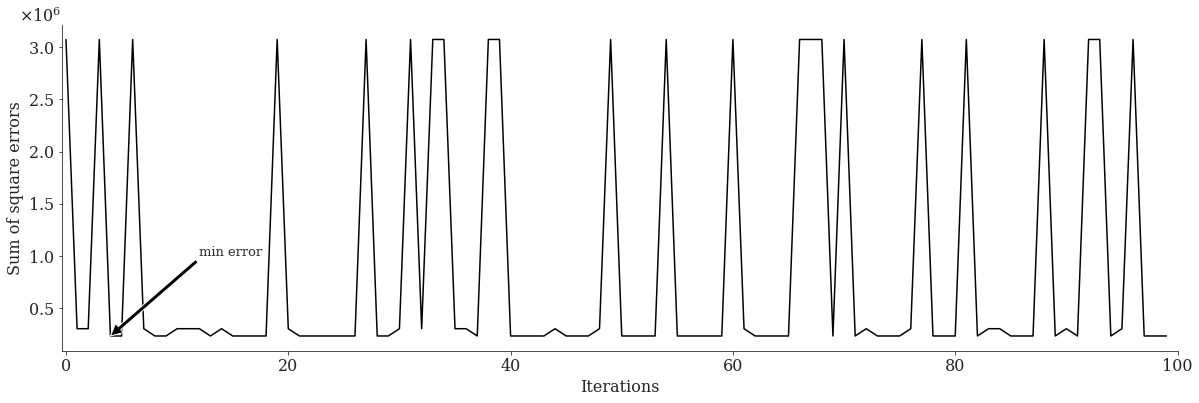

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.grid(False)
hide_box(ax)
plt.xlabel('Iterations',fontsize=16)
plt.ylabel('Sum of square errors',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ticklabel_format(axis='y',style='sci',useMathText=True,scilimits=(1000,1000))
ax.yaxis.offsetText.set_fontsize(16)
ax.yaxis.offsetText.set_position([-0.038,0])
ax.plot(np.sum(errors,axis=1)[:100],c='k')
# plt.ylim(ymin=-2)
plt.xlim(xmin=-0.4, xmax=100)
plt.annotate('min error', xy=(np.sum(errors,axis=1).argmin(), np.sum(errors,axis=1).min()), xytext=(np.sum(errors,axis=1).argmin()+8, 1000000),
            arrowprops=dict(facecolor='black'),size=13
            )

In [20]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

src_pts = np.float32([ kp1[m.queryIdx] for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx] for m in good ]).reshape(-1,1,2)

In [21]:
src_pts

array([[[831.10815, 182.32933]]], dtype=float32)

In [22]:
dst_pts

array([[[971.23486, 220.4223 ]]], dtype=float32)